In [1]:
from pathlib import Path
from typing import Optional, Tuple, Union, Callable, Literal

import os
import math
import importlib.util

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import masknmf
from masknmf.compression.pmd_array import PMDArray
from masknmf.utils import torch_select_device
from masknmf import display

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

No windowing system present. Using surfaceless platform
No config found!
No config found!
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),Quadro RTX 8000,DiscreteGPU,Vulkan,565.57.01
✅,Quadro RTX 8000,DiscreteGPU,Vulkan,565.57.01
❌,Quadro RTX 8000/PCIe/SSE2,Unknown,OpenGL,3.3.0 NVIDIA 565.57.01


Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


Using device: cuda


In [2]:
class MotionBinDataset:
    """Load a memmapped suite2p data.bin together with metadata (.npy/.zip)."""
    
    def __init__(self, data_path: str, metadata_path: str, dtype=np.int16):
        self.bin_path = Path(data_path)
        self.ops_path = Path(metadata_path)
        self._dtype = dtype
        self._shape = self._compute_shape()
        self.data = np.memmap(self.bin_path, mode='r', dtype=self._dtype, shape=self._shape)

    def _compute_shape(self) -> Tuple[int, int, int]:
        _, ext = os.path.splitext(self.ops_path)
        if ext == ".zip":
            ops = np.load(self.ops_path, allow_pickle=True)['ops'].item()
        elif ext == ".npy":
            ops = np.load(self.ops_path, allow_pickle=True).item()
        else:
            raise ValueError("Metadata file must be .zip or .npy")
        return int(ops['nframes']), int(ops['Ly']), int(ops['Lx'])

    @property
    def shape(self) -> Tuple[int, int, int]:
        return self._shape

    def __getitem__(self, item):
        return self.data[item].copy()

my_data = MotionBinDataset(
    '/burg-archive/home/lm3879/plane4/data.bin',
    '/burg-archive/home/lm3879/plane4/ops.npy'
)
T, H, W = my_data.shape
dtype = torch.float32


In [3]:
# Utility functions copied from the original decomposition.py
def truncated_random_svd(
        input_matrix: torch.tensor, rank: int, num_oversamples: int = 5, device: str = "cpu"
) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
    """
    Assumptions:
    (1) input_matrix has been adequately mean-subtracted (so every column has mean 0, at least over the full dataset)
    (2) rank + num_oversamples is less than all dimensions of input_matrix.
    """
    num_frames = input_matrix.shape[1]
    input_matrix = input_matrix.to(device)
    random_data = torch.randn(num_frames, rank + num_oversamples, device=device)
    projected = input_matrix @ random_data
    q, r = torch.linalg.qr(projected, mode="reduced")
    b = q.T @ input_matrix
    u, s, v = torch.linalg.svd(b, full_matrices=False)
    u_final = q @ u
    v_final = v
    return u_final[:, :rank], s[:rank], v_final[:rank, :]
    
def check_fov_size(fov_dims: Tuple[int, int], min_allowed_value: int = 10) -> None:
    """
    Checks if the field of view (FOV) dimensions are too small.

    Args:
        fov_dims (tuple): Two integers specifying the FOV dimensions.
        min_allowed_value (int, optional): The minimum allowed value for FOV dimensions. Defaults to 10.

    Returns:
        None

    Raises:
        ValueError: If either field of view dimension is less than the minimum allowed value.
    """
    for k in fov_dims:
        if k < min_allowed_value:
            raise ValueError(
                "At least one FOV dimension is lower than {}, "
                "too small to process".format(min_allowed_value)
            )

def identify_window_chunks(
        frame_range: int, total_frames: int, window_chunks: int
) -> list:
    """
    Args:
        frame_range (int): Number of frames to fit
        total_frames (int): Total number of frames in the movie
        window_chunks (int): We sample continuous chunks of data throughout the movie.
            Each chunk is of size "window_chunks"

    Returns:
        (list): Contains the starting point of the intervals
            (each of length "window_chunk") on which we do the decomposition.

    Key requirements:
        (1) frame_range should be less than total number of frames
        (2) window_chunks should be less than or equal to frame_range
    """
    if frame_range > total_frames:
        raise ValueError("Requested more frames than available")
    if window_chunks > frame_range:
        raise ValueError("The size of each temporal chunk is bigger than frame range")

    num_intervals = math.ceil(frame_range / window_chunks)

    available_intervals = np.arange(0, total_frames, window_chunks)
    if available_intervals[-1] > total_frames - window_chunks:
        available_intervals[-1] = total_frames - window_chunks
    starting_points = np.random.choice(
        available_intervals, size=num_intervals, replace=False
    )
    starting_points = np.sort(starting_points)
    display("sampled from the following regions: {}".format(starting_points))

    net_frames = []
    for k in starting_points:
        curr_start = k
        curr_end = min(k + window_chunks, total_frames)

        curr_frame_list = [i for i in range(curr_start, curr_end)]
        net_frames.extend(curr_frame_list)
    return net_frames

def update_block_sizes(
        blocks: tuple,
        fov_shape: tuple,
        min_block_value: int = 4,
) -> list:
    """
    If user specifies block sizes that are too large, this approach truncates the blocksizes appropriately

    Args:
        blocks (tuple): Two integers, specifying the height and width blocksizes used in compression
        fov_shape (tuple): The height and width of the FOV
        min_block_value (int): The minimum value of a block in either spatial dimension.

    Returns:
        list: A list containing the updated block sizes

    Raises:
        ValueError if either block dimension is less than min allowed value.
    """
    if blocks[0] < min_block_value or blocks[1] < min_block_value:
        raise ValueError(
            "One of the block dimensions was less than min allowed value of {}, "
            "set to a larger value".format(min_block_value)
        )
    final_blocks = []
    if blocks[0] > fov_shape[0]:
        display(
            "Height blocksize was set to {} but corresponding dimension has size {}. Truncating to {}".format(
                blocks[0], fov_shape[0], fov_shape[0]
            )
        )
        final_blocks.append(fov_shape[0])
    else:
        final_blocks.append(blocks[0])
    if blocks[1] > fov_shape[1]:
        display(
            "Height blocksize was set to {} but corresponding dimension has size {}. Truncating to {}".format(
                blocks[1], fov_shape[1], fov_shape[1]
            )
        )
        final_blocks.append(fov_shape[1])
    else:
        final_blocks.append(blocks[1])
    return final_blocks

def compute_mean_and_normalizer_dataset(
        dataset: Union[masknmf.ArrayLike, masknmf.LazyFrameLoader],
        compute_normalizer: bool,
        pixel_batch_size: int,
        device: str,
        dtype: torch.dtype,
) -> Tuple[torch.tensor, torch.tensor]:
    """
    Computes a pixelwise mean and a noise variance estimate. For now, the noise var estimate is turned off
    Args:
        dataset (Union[masknmf.ArrayLike, masknmf.LazyFrameLoader]): The dataloader object we use to access the dataset. Anything that supports
            numpy-like __getitem__ indexing can be used here.
        compute_normalizer (bool): Whether or not we compute the noise normalizer; for now this variable has no effect.
        pixel_batch_size (int): The number of pixels in each dimension to load at a time
        dtype (torch.dtype): The dtype of the data once it has been moved to accelerator.
        device (str): The
    Returns:
        mean_img (torch.tensor): The (fov dim1, fov dim2) shaped mean image.
        var_img (torch.tensor): The (fvo dim1, fov dim2) noise variance image.
    """
    num_frames, fov_dim1, fov_dim2 = dataset.shape

    height_iters = math.ceil(fov_dim1 / pixel_batch_size)
    width_iters = math.ceil(fov_dim2 / pixel_batch_size)

    noise_normalizer = torch.zeros((fov_dim1, fov_dim2), dtype=dtype, device=device)
    mean_value = torch.zeros((fov_dim1, fov_dim2), dtype=dtype, device=device)

    for i in range(height_iters):
        for j in range(width_iters):
            start_height = pixel_batch_size * i
            end_height = min(fov_dim1, start_height + pixel_batch_size)
            start_width = pixel_batch_size * j
            end_width = min(fov_dim2, start_width + pixel_batch_size)

            data_subset = torch.from_numpy(dataset[:, start_height:end_height, start_width:end_width]).to(device).to(dtype)
            mean_value[start_height:end_height, start_width:end_width] = torch.mean(data_subset, dim=0)
            if compute_normalizer:
                data_subset -= mean_value[start_height:end_height, start_width:end_width][None, :, :]
                noise_term = ((torch.sum(data_subset**2, dim=0)/num_frames) -
                              (torch.sum(data_subset[1:, :, :]*data_subset[:-1, :, :], dim=0)) / (num_frames-1))
                noise_normalizer[start_height:end_height, start_width:end_width] = torch.sqrt(noise_term)

    noise_normalizer[noise_normalizer <= 0] = 1.0
    return mean_value.cpu(), noise_normalizer.cpu()

def construct_weighting_scheme(dim1, dim2) -> torch.tensor:
    # Define the block weighting matrix
    block_weights = np.ones((dim1, dim2), dtype=np.float32)
    hbh = dim1 // 2
    hbw = dim2 // 2
    # Increase weights to value block centers more than edges
    block_weights[:hbh, :hbw] += np.minimum(
        np.tile(np.arange(0, hbw), (hbh, 1)), np.tile(np.arange(0, hbh), (hbw, 1)).T
    )
    block_weights[:hbh, hbw:] = np.fliplr(block_weights[:hbh, :hbw])
    block_weights[hbh:, :] = np.flipud(block_weights[:hbh, :])
    block_weights = torch.from_numpy(block_weights)
    return block_weights

def threshold_heuristic(
        dimensions: Tuple[int, int, int],
        spatial_avg_factor: int,
        temporal_avg_factor: int,
        spatial_denoiser: Optional[torch.nn.Module],
        temporal_denoiser: Optional[torch.nn.Module],
        dtype: torch.dtype,
        num_comps: int = 1,
        iters: int = 250,
        percentile_threshold: float = 5,
        device: str = "cpu",
) -> Tuple[float, float]:
    """
    Generates a histogram of spatial and temporal roughness statistics from running the decomposition on random noise.
    This is used to decide how "smooth" the temporal and spatial components need to be in order to contain signal.

    Args:
        dimensions (tuple): Tuple describing the dimensions of the blocks which we will
            decompose. Contains (d1, d2, T), the two spatial field of view dimensions and the number of frames
        spatial_avg_factor (int): The factor (in both spatial dimensions) by which we downsample the data to get higher SNR estimates
        temporal_avg_factor (int): The factor (in time dimension) by which we downsample the data to get higher SNR estimates
        spatial_denoiser (Optional[torch.nn.Module]): A spatial denoiser module for denoising spatial basis vectors
        temporal_denoiser (Optional[torch.nn.Module]): A temporal denoiser module for denoising (batch_size, timeseries_length)
            shaped time series data
        dtype (torch.dtype): the dtype that all tensors must have
        num_comps (int): The number of components which we identify in the decomposition
        iters (int): The number of times we run this simulation procedure to collect a histogram of spatial and temporal
            roughness statistics
        percentile_threshold (float): The threshold we use to decide whether the spatial and temporal roughness stats of
            decomposition are "smooth" enough to contain signal.

    Returns:
        tuple[float, float]: The spatial and temporal "cutoffs" for deciding whether a spatial-temporal decomposition
            contains signals.

    """
    spatial_list = []
    temporal_list = []

    d1, d2, t = dimensions
    sim_mean = torch.zeros((d1, d2), device=device, dtype=dtype)
    sim_noise_normalizer = torch.ones((d1, d2), device=device, dtype=dtype)
    pixel_weighting = torch.ones((d1, d2), device=device, dtype=dtype)
    max_components = num_comps

    for k in tqdm(range(iters)):
        sim_data = torch.randn(t, d1 * d2, device=device, dtype=dtype).reshape(
            (t, d1, d2)
        )

        spatial, temporal = blockwise_decomposition(
            sim_data,
            sim_mean,
            sim_noise_normalizer,
            pixel_weighting,
            max_components,
            spatial_avg_factor,
            temporal_avg_factor,
            dtype,
            spatial_denoiser=spatial_denoiser,
            temporal_denoiser=temporal_denoiser,
            device=device,
        )

        spatial_stat = spatial_roughness_statistic(spatial)
        temporal_stat = temporal_roughness_statistic(temporal)
        spatial_list.append(spatial_stat)
        temporal_list.append(temporal_stat)

    spatial_list = torch.concatenate(spatial_list, dim=0).cpu().numpy()
    temporal_list = torch.concatenate(temporal_list, dim=0).cpu().numpy()

    spatial_threshold = np.percentile(spatial_list.flatten(), percentile_threshold)
    temporal_threshold = np.percentile(temporal_list.flatten(), percentile_threshold)
    return spatial_threshold, temporal_threshold

def regress_onto_spatial_basis(
        dataset: Union[masknmf.ArrayLike, masknmf.LazyFrameLoader],
        u_aggregated: torch.sparse_coo_tensor,
        frame_batch_size: int,
        dataset_mean: torch.tensor,
        dataset_noise_variance: torch.tensor,
        dtype: torch.dtype,
        device: str = "cpu",
) -> torch.tensor:
    """
    We have a spatial basis from blockwise decompositions. This function will do two things, in a single pass through the
    data:
        (1) It will project the data onto each block's orthogonal basis (this is NOT equivalent to a linear subspace projection onto the
        spatial basis!)
        (2) It will perform a linear subspace projection of the centered+standardized data onto the full FOV data

    The computation to perform here is:
    v_aggregate = u^T (I_{norms} * (Data - Mean) - Spatial_Full_FOV_Bkgd * Temporal_Full_FOV_Bkgd)
    Here, I_{norms} is a diagonal matrix containing the reciprocal of the dataset_noise_variance. The term
    I_{norms}(Data - Mean) does pixelwise centering + standardization of the data.
    In the below routine, we exploit the low rank of u and conduct operations in an order that minimizes data size/number of computations.

    Args:
        dataset (Union[masknmf.ArrayLike, masknmf.LazyFrameLoader]): Any array-like object that supports __getitem__ for fast frame retrieval.
        u_aggregated (torch.sparse_coo_tensor): The spatial basis, where components from the same block are orthonormal.
        frame_batch_size (int): The number of frames we load at any point in time
        dataset_mean (torch.tensor): Shape (fov_dim1, fov_dim2). The mean across all pixels
        dataset_noise_variance (torch.tensor): Shape (fov_dim1, fov_dim2). The noise variance across all pixels.
        dtype (torch.dtype): The dtype to which we convert the data for processing; should be torch.float32, or float64.
        device (str): The platform on which processing occurs ("cuda" or "cpu")
    """
    num_frames, fov_dim1, fov_dim2 = dataset.shape
    num_iters = math.ceil(dataset.shape[0] / frame_batch_size)
    dataset_mean = dataset_mean.to(device).to(dtype).reshape((fov_dim1 * fov_dim2, 1))
    dataset_noise_variance = (
        dataset_noise_variance.to(device).to(dtype).reshape((fov_dim1 * fov_dim2, 1))
    )

    u_t = u_aggregated.T.coalesce()

    row_indices, col_indices = u_t.indices()
    ut_values = u_t.values()

    new_values = ut_values / dataset_noise_variance[col_indices].squeeze()

    u_t_normalized = torch.sparse_coo_tensor(
        u_t.indices(), new_values, u_t.shape
    ).coalesce()

    mean_projected = torch.sparse.mm(u_t_normalized, dataset_mean)

    temporal_results = []
    for k in tqdm(range(num_iters)):
        start_pt = k * frame_batch_size
        end_pt = min(start_pt + frame_batch_size, num_frames)
        curr_data = dataset[start_pt:end_pt]
        if isinstance(curr_data, np.ndarray):
            curr_data = torch.from_numpy(curr_data).to(device).to(dtype).permute(1, 2, 0).reshape((fov_dim1*fov_dim2,-1))
        elif isinstance(curr_data, torch.Tensor):
            curr_data = curr_data.to(device).to(dtype).permute(1, 2, 0).reshape((fov_dim1*fov_dim2,-1))
        else:
            raise ValueError(f"Dataset returns data of type {type(curr_data)}. Only valid return types are np.ndarray and torch.tensor")

        projection = torch.sparse.mm(u_t_normalized, curr_data)
        projection -= mean_projected


        ## Add the full fov and blockwise temporal components that we estimate above to a list to concatenate later
        temporal_results.append(projection)
    return torch.concatenate(temporal_results, dim=1)

def blockwise_decomposition_with_rank_selection(
        video_subset: torch.tensor,
        subset_mean: torch.tensor,
        subset_noise_variance: torch.tensor,
        subset_pixel_weighting: torch.tensor,
        max_components: int,
        max_consecutive_failures: int,
        spatial_roughness_threshold: float,
        temporal_roughness_threshold: float,
        spatial_avg_factor: int,
        temporal_avg_factor: int,
        dtype: torch.dtype,
        spatial_denoiser: Optional[torch.nn.Module] = None,
        temporal_denoiser: Optional[torch.nn.Module] = None,
        device: str = "cpu",
):
    local_spatial_basis, local_temporal_basis = blockwise_decomposition(
        video_subset,
        subset_mean,
        subset_noise_variance,
        subset_pixel_weighting,
        max_components,
        spatial_avg_factor,
        temporal_avg_factor,
        dtype,
        spatial_denoiser=spatial_denoiser,
        temporal_denoiser=temporal_denoiser,
        device=device,
    )

    decisions = evaluate_fitness(
        local_spatial_basis,
        local_temporal_basis,
        spatial_roughness_threshold,
        temporal_roughness_threshold,
    )

    decisions = filter_by_failures(decisions, max_consecutive_failures)
    return local_spatial_basis[:, :, decisions], local_temporal_basis[decisions, :]

def blockwise_decomposition(
        video_subset: torch.tensor,
        subset_mean: torch.tensor,
        subset_noise_variance: torch.tensor,
        subset_pixel_weighting: torch.tensor,
        max_components: int,
        spatial_avg_factor: int,
        temporal_avg_factor: int,
        dtype: torch.dtype,
        spatial_denoiser: Optional[Callable] = None,
        temporal_denoiser: Optional[Callable] = None,
        device: str = "cpu",
) -> Tuple[torch.tensor, torch.tensor]:

    first_spatial, first_temporal = blockwise_decomposition_singlepass(video_subset,
                                                                       subset_mean,
                                                                       subset_noise_variance,
                                                                       subset_pixel_weighting,
                                                                       max_components,
                                                                       spatial_avg_factor,
                                                                       temporal_avg_factor,
                                                                       dtype,
                                                                       spatial_denoiser=spatial_denoiser,
                                                                       temporal_denoiser=temporal_denoiser,
                                                                       device=device)

    return first_spatial, first_temporal

def temporal_roughness_statistic(temporal_traces: torch.tensor) -> torch.tensor:
    """
    Computes the temporal roughness statistics, batched over all the traces of interest
    Args:
        temporal_traces (torch.tensor): shape (num_traces, num_frames).
    Returns:
        stats (torch.tensor): shape (num_traces)
    """
    left_term = temporal_traces[:, :-2]
    right_term = temporal_traces[:, 2:]
    center_term = temporal_traces[:, 1:-1]

    numerator = torch.mean(torch.abs(left_term + right_term - 2 * center_term), dim=1)
    denominator = torch.mean(torch.abs(temporal_traces), dim=1)
    denominator[denominator == 0] = 1.0
    return numerator / denominator

def spatial_roughness_statistic(spatial_comps: torch.tensor) -> torch.tensor:
    """
    Computes spatial roughness statistic, batched over all spatial comps of interest
    Args:
        spatial_comps (torch.tensor): shape (fov dim1, fov dim2, num_components)
    Returns:
        stats (torch.tensor): shape (num_components)
    """
    d1, d2 = spatial_comps.shape[0], spatial_comps.shape[1]
    # Compute abs(vertical differences) :
    top_vertical = spatial_comps[:-1, :, :]
    bottom_vertical = spatial_comps[1:, :, :]
    vertical_diffs = torch.abs(top_vertical - bottom_vertical)

    # Compute abs(horizontal differences)
    left_horizontal = spatial_comps[:, :-1, :]
    right_horizontal = spatial_comps[:, 1:, :]
    horizontal_diffs = torch.abs(left_horizontal - right_horizontal)

    # Compute abs(top left --> bottom right differences)
    top_left = spatial_comps[:-1, :-1, :]
    bottom_right = spatial_comps[1:, 1:, :]
    top_bottom_diag_diffs = torch.abs(top_left - bottom_right)

    # Compute abs(bottomleft --> topright differences)
    top_right = spatial_comps[1:, 1:, :]
    bottom_left = spatial_comps[:-1, :-1, :]
    bottom_top_diag_diffs = torch.abs(top_right - bottom_left)

    total_terms = (
            torch.prod(torch.tensor(vertical_diffs.shape[:2]))
            + torch.prod(torch.tensor(horizontal_diffs.shape[:2]))
            + torch.prod(torch.tensor(top_bottom_diag_diffs.shape[:2]))
            + torch.prod(torch.tensor(bottom_top_diag_diffs.shape[:2]))
    )

    avg_diff = (
            torch.sum(vertical_diffs, dim=(0, 1))
            + torch.sum(horizontal_diffs, dim=(0, 1))
            + torch.sum(top_bottom_diag_diffs, dim=(0, 1))
            + torch.sum(top_bottom_diag_diffs, dim=(0, 1))
    )
    avg_diff /= total_terms

    return avg_diff / torch.mean(torch.abs(spatial_comps), dim=(0, 1))


def evaluate_fitness(
        spatial_comps: torch.tensor,
        temporal_traces: torch.tensor,
        spatial_statistic_threshold: float,
        temporal_statistic_threshold: float,
) -> torch.tensor:
    """
    Args:
        spatial_comps (torch.tensor): shape (fov dim1, fov dim2, num_components)
        temporal_traces (torch.tensor): shape (num_components, num_frames)
        spatial_statistic_threshold (float): All accepted comps have a spatial roughness LESS than this threshold
        temporal_statistic_threshold (float): All accepted comps have a temporal roughness LESS than this threshold
    Returns:

    """
    evaluated_spatial_stats = spatial_roughness_statistic(spatial_comps)
    evaluated_temporal_stats = temporal_roughness_statistic(temporal_traces)

    spatial_decisions = evaluated_spatial_stats < spatial_statistic_threshold
    temporal_decisions = evaluated_temporal_stats < temporal_statistic_threshold

    return torch.logical_and(spatial_decisions, temporal_decisions)


def filter_by_failures(
        decisions: torch.tensor, max_consecutive_failures: int
) -> torch.tensor:
    """
    Filters decisions based on maximum consecutive failures.

    Args:
        decisions (np.ndarray): 1-dimensional array of boolean values representing decisions.
        max_consecutive_failures (int): Maximum number of consecutive failures (ie decisions[i] == 0) allowed.

    Returns:
        np.ndarray: Filtered decisions with the same shape and type as input decisions.
    """

    false_tensor = (~decisions).to(dtype=torch.float32)
    kernel = torch.ones(
        max_consecutive_failures, device=false_tensor.device, dtype=torch.float32
    )[
             None, None, :
             ]  # Shape (1,1,n)
    seq = false_tensor.to(torch.float32)[None, None, :]

    # Convolve to find runs of n consecutive False values
    conv_result = torch.nn.functional.conv1d(
        seq, kernel, stride=1, padding=max_consecutive_failures - 1
    ).squeeze(0, 1)[: false_tensor.shape[0]]

    over_threshold = (conv_result >= max_consecutive_failures).to(torch.float32)
    keep_comps = (
            torch.cumsum(torch.cumsum(over_threshold, dim=0), dim=0) <= 1
    )  ##Two cumulative sums guarantee we pick the last element properly

    return keep_comps

def blockwise_decomposition_singlepass(
        video_subset: torch.tensor,
        subset_mean: torch.tensor,
        subset_noise_variance: torch.tensor,
        subset_pixel_weighting: torch.tensor,
        max_components: int,
        spatial_avg_factor: int,
        temporal_avg_factor: int,
        dtype: torch.dtype,
        spatial_denoiser: Optional[Callable] = None,
        temporal_denoiser: Optional[Callable] = None,
        device: str = "cpu",
) -> Tuple[torch.tensor, torch.tensor]:
    num_frames, fov_dim1, fov_dim2 = video_subset.shape
    empty_values = torch.zeros((fov_dim1, fov_dim2, 1), device=device, dtype=dtype), torch.zeros((1, num_frames),
                                                                                                 device=device,
                                                                                                 dtype=dtype)
    subset = video_subset.to(device).to(dtype)
    subset = subset - subset_mean.to(device).to(dtype)[None, :, :]
    subset /= subset_noise_variance.to(device).to(dtype)[None, :, :]
    subset = subset.permute(1, 2, 0)
    subset_weighted = subset * subset_pixel_weighting.to(device).to(dtype)[:, :, None]

    if spatial_avg_factor != 1:
        spatial_pooled_subset = spatial_downsample(subset_weighted, spatial_avg_factor)
    else:
        spatial_pooled_subset = subset_weighted

    spatial_pooled_subset_r = spatial_pooled_subset.reshape(
        (-1, spatial_pooled_subset.shape[2])
    )

    if temporal_avg_factor != 1:
        spatiotemporal_pooled_subset = temporal_downsample(
            spatial_pooled_subset, temporal_avg_factor
        )
        spatiotemporal_pooled_subset -= torch.mean(spatiotemporal_pooled_subset, dim=2, keepdim=True)
    else:
        spatiotemporal_pooled_subset = spatial_pooled_subset

    spatiotemporal_pooled_subset_r = spatiotemporal_pooled_subset.reshape(
        (-1, spatiotemporal_pooled_subset.shape[2])
    )

    lowres_spatial_basis_r, interm_sing_values, _ = truncated_random_svd(
        spatiotemporal_pooled_subset_r, max_components, device=device
    )
    if torch.count_nonzero(interm_sing_values) == 0:
        return empty_values

    temporal_projection_from_downsample = (
            lowres_spatial_basis_r.T @ spatial_pooled_subset_r
    )
    if temporal_denoiser is not None:
        temporal_projection_from_downsample = temporal_denoiser(
            temporal_projection_from_downsample
        )
    std_values = torch.std(temporal_projection_from_downsample, dim=1)
    if torch.count_nonzero(std_values) == 0:
        return empty_values
    else:
        temporal_projection_from_downsample = temporal_projection_from_downsample[std_values != 0]

    if temporal_denoiser is None or temporal_projection_from_downsample.shape[0] <= 1:
        temporal_basis_from_downsample = _temporal_basis_pca(temporal_projection_from_downsample,
                                                             explained_var_cutoff=1.0)
    else:
        temporal_basis_from_downsample = _temporal_basis_pca(temporal_projection_from_downsample,
                                                             explained_var_cutoff=0.99)

    subset_weighted_r = subset_weighted.reshape((-1, subset_weighted.shape[2]))
    spatial_basis_fullres = subset_weighted_r @ temporal_basis_from_downsample.T

    if spatial_denoiser is not None:
        spatial_basis_fullres = spatial_basis_fullres.reshape((fov_dim1, fov_dim2, -1))
        spatial_basis_fullres = spatial_denoiser(spatial_basis_fullres)
        spatial_basis_fullres = spatial_basis_fullres.reshape((fov_dim1 * fov_dim2, -1))

    spatial_basis_orthogonal, interm_sing_vals, _ = torch.linalg.svd(
        spatial_basis_fullres, full_matrices=False
    )
    if torch.count_nonzero(interm_sing_vals) == 0:
        return empty_values
    else:
        spatial_basis_orthogonal = spatial_basis_orthogonal[:, interm_sing_vals != 0]

    # Regress the original (unweighted) data onto this basis
    subset_r = subset.reshape((-1, subset.shape[2]))
    final_temporal_projection = spatial_basis_orthogonal.T @ subset_r
    left, sing, right = torch.linalg.svd(final_temporal_projection, full_matrices=False)
    if torch.count_nonzero(sing) == 0:
        return empty_values
    else:
        indices_to_keep = sing != 0
        left = left[:, indices_to_keep]
        right = right[indices_to_keep, :]
        sing = sing[indices_to_keep]
    local_spatial_basis = (spatial_basis_orthogonal @ left).reshape(
        (fov_dim1, fov_dim2, -1)
    )
    local_temporal_basis = sing[:, None] * right

    if temporal_denoiser is not None:
        local_temporal_basis = temporal_denoiser(local_temporal_basis)
        if torch.count_nonzero(local_temporal_basis) == 0:
            return empty_values
        else:
            local_temporal_basis -= torch.mean(local_temporal_basis, dim=1, keepdims=True)

    return local_spatial_basis, local_temporal_basis

def spatial_downsample(
        image_stack: torch.Tensor, spatial_avg_factor: int
) -> torch.Tensor:
    """
    Downsamples a (height, width, num_frames) image stack via n x n binning.

    Args:
        image_stack: Tensor of shape (height, width, num_frames).

    Returns:
        Downsampled tensor of shape (H//factor, W//factor, T).
    """

    image_stack = image_stack.permute(2, 0, 1).unsqueeze(
        1
    )  # (num_frames, 1, height, width)
    downsampled = torch.nn.functional.avg_pool2d(
        image_stack, kernel_size=spatial_avg_factor, stride=spatial_avg_factor
    )  # (T, 1, H//2, W//2)
    return downsampled.squeeze(1).permute(1, 2, 0)


def _temporal_basis_pca(temporal_basis: torch.tensor,
                        explained_var_cutoff: float = 0.99) -> torch.tensor:
    """
    Keeps the top "k" PCA components of temporal_basis that explain >= explained_var_cutoff of the variance
    Args:
        temporal_basis (torch.tensor): Shape (number_of_timeseries, num_timesteps).
        explained_var_cutoff (float): Float between 0 and 1, describes how much of the net variance these comps
            should explain. Default value of 0.99 makes sense when you are processing data that has been smoothed
            already via some denoising algorithm - this should shift the signal subspace to the top of the spectrum.
    Returns:
        truncated_temporal_basis (torch.tensor): Shape (truncated_num_of_timeseries, num_timesteps). Truncated basis
    """
    temporal_basis_mean = torch.mean(temporal_basis, dim=1, keepdim=True)
    temporal_basis_meansub = temporal_basis - temporal_basis_mean
    _, sing, right_vec = torch.linalg.svd(temporal_basis_meansub, full_matrices=False)
    explained_ratios = torch.cumsum(sing ** 2, dim=0) / torch.sum(sing ** 2, dim=0)

    ind = torch.nonzero(explained_ratios >= explained_var_cutoff, as_tuple=True)
    if ind[0].numel() == 0:
        ind = temporal_basis.shape[0]
    else:
        ind = ind[0][0].item() + 1
    new_basis = right_vec[:ind, :]
    return new_basis

def temporal_downsample(tensor: torch.Tensor, temporal_avg_factor: int) -> torch.Tensor:
    """
    Temporally downsamples a (height, width, num_frames) tensor using avg_pool1d.

    Args:
        tensor: Input tensor of shape (num_frames, height, width).
        n: Downsampling factor (number of frames per block).

    Returns:
        Downsampled tensor of shape (height, width, ceil(num_frames / n)).
    """
    height, width, num_frames = tensor.shape
    tensor = tensor.reshape(height * width, num_frames).unsqueeze(1)
    downsampled = torch.nn.functional.avg_pool1d(
        tensor,
        kernel_size=temporal_avg_factor,
        stride=temporal_avg_factor,
        ceil_mode=True,
    )

    # Reshape back to (num_frames // n, height, width)
    return downsampled.squeeze().reshape(height, width, -1)

In [4]:
def _align_sign(u_ref, u_tgt):
    if np.sum(u_ref * u_tgt) < 0:
        return -u_tgt, -1.0
    return u_tgt, 1.0

def _corr(a, b, eps=1e-12):
    a = a.reshape(-1) - a.mean()
    b = b.reshape(-1) - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + eps
    return float((a @ b) / denom)

def save_block_comp_pages_4col_v3style(
    samples,
    out_dir="viz_blocks",
    prefix="u_block_comp0",
    per_fig=10,
    top_n=40,
    dpi=180,
    cmap_main="RdBu_r",
    cmap_diff="seismic",
    pad_h=8, pad_w=8, h0=32, w0=32,
):
    os.makedirs(out_dir, exist_ok=True)
    if len(samples) == 0:
        print("no samples")
        return []

    samples = sorted(samples, key=lambda s: s.get("score", 0.0), reverse=True)[:top_n]

    n = len(samples)
    paths = []
    num_pages = (n + per_fig - 1) // per_fig

    for p in range(num_pages):
        chunk = samples[p * per_fig : (p + 1) * per_fig]
        rows = len(chunk)

        fig, axs = plt.subplots(rows, 4, figsize=(18, 3.2 * rows))
        if rows == 1:
            axs = np.expand_dims(axs, 0)

        for r, s in enumerate(chunk):
            u0 = np.asarray(s["u0"])       # (32,32) temp
            u1 = np.asarray(s["u1"])       # (32,32) trunc
            uE = np.asarray(s["uexp_48"])  # (48,48) expanded

            # sign align u1/uE to u0
            u1a, sgn = _align_sign(u0, u1)
            uEa = uE * sgn

            diff = u1a - u0  # v3: trunc - temp
            c = _corr(u0, u1a)
            mse = float(np.mean(diff**2))

            vmax = float(max(np.max(np.abs(u0)), np.max(np.abs(u1a)), np.max(np.abs(uEa))) + 1e-12)
            vmax_diff = float(np.max(np.abs(diff)) + 1e-12)

            # Col1 u_temp
            im0 = axs[r, 0].imshow(u0, cmap=cmap_main, vmin=-vmax, vmax=vmax)
            axs[r, 0].axis("off")
            axs[r, 0].set_title(f"u_temp  (k={s['k']}, j={s['j']})", fontsize=10)
            plt.colorbar(im0, ax=axs[r, 0], fraction=0.046, pad=0.04)

            # Col2 u_trunc aligned
            im1 = axs[r, 1].imshow(u1a, cmap=cmap_main, vmin=-vmax, vmax=vmax)
            axs[r, 1].axis("off")
            axs[r, 1].set_title(f"u_trunc aligned\nsign={sgn:+.0f}, corr={c:.3f}", fontsize=10)
            plt.colorbar(im1, ax=axs[r, 1], fraction=0.046, pad=0.04)

            # Col3 diff
            im2 = axs[r, 2].imshow(diff, cmap=cmap_diff, vmin=-vmax_diff, vmax=vmax_diff)
            axs[r, 2].axis("off")
            axs[r, 2].set_title(f"diff (trunc-temp)\nMSE={mse:.2e}", fontsize=10)
            plt.colorbar(im2, ax=axs[r, 2], fraction=0.046, pad=0.04)

            # Col4 u_expanded aligned + box
            im3 = axs[r, 3].imshow(uEa, cmap=cmap_main, vmin=-vmax, vmax=vmax)
            axs[r, 3].axis("off")
            axs[r, 3].set_title("u_expanded aligned\n(box=original 32×32)", fontsize=10)

            rect = patches.Rectangle(
                (pad_w, pad_h), w0, h0,
                linewidth=2, edgecolor="yellow", facecolor="none"
            )
            axs[r, 3].add_patch(rect)
            plt.colorbar(im3, ax=axs[r, 3], fraction=0.046, pad=0.04)

        plt.tight_layout()
        path = os.path.join(out_dir, f"{prefix}_page{p+1:02d}.png")
        fig.savefig(path, dpi=dpi, bbox_inches="tight")
        plt.show()
        plt.close(fig)
        paths.append(path)

    print(f"Saved {len(paths)} figures to: {out_dir}")
    return paths

def score_cell_like_np(img: np.ndarray) -> float:
    x = img.astype(np.float32)
    x = x - x.mean()

    k3 = np.ones((3,3), np.float32) / 9.0
    k7 = np.ones((7,7), np.float32) / 49.0

    def conv2(a, k):
        H,W = a.shape
        kh,kw = k.shape
        ph,pw = kh//2, kw//2
        ap = np.pad(a, ((ph,ph),(pw,pw)), mode="reflect")
        out = np.empty_like(a)
        for i in range(H):
            for j in range(W):
                out[i,j] = np.sum(ap[i:i+kh, j:j+kw] * k)
        return out

    s3 = conv2(x, k3)
    s7 = conv2(x, k7)
    hp = s3 - s7

    med = np.median(hp)
    mad = np.median(np.abs(hp - med)) + 1e-6
    z = (hp - med) / mad
    return float(np.mean(np.clip(z, 0, None)**2))
    
def temporal_energy_np(v_row: np.ndarray) -> float:
    v = v_row.astype(np.float32)
    v = v - v.mean()
    return float(np.mean(v*v))

def _reflect_index_1d(idx: torch.Tensor, n: int) -> torch.Tensor:
    """
    Reflect index into [0, n-1] with reflect (no edge repeat) behavior.
    """
    if n <= 1:
        return torch.zeros_like(idx)
    period = 2 * (n - 1)
    m = torch.remainder(idx, period)
    return torch.where(m <= (n - 1), m, period - m)

def reflect_take_2d(img_hw: torch.Tensor, top: int, left: int, h: int, w: int) -> torch.Tensor:
    """
    img_hw: (H,W) torch tensor (any device)
    returns: (h,w) reflect-padded crop
    """
    H, W = img_hw.shape
    rr = torch.arange(top, top + h, device=img_hw.device, dtype=torch.long)
    cc = torch.arange(left, left + w, device=img_hw.device, dtype=torch.long)
    rr = _reflect_index_1d(rr, H).to(torch.long)
    cc = _reflect_index_1d(cc, W).to(torch.long)
    return img_hw.index_select(0, rr).index_select(1, cc)

def reflect_take_video_torch(
    vid_thw: torch.Tensor,  # (T,H,W)
    frames_t: torch.Tensor, # (Tf,) long
    top: int,
    left: int,
    h: int,
    w: int,
) -> torch.Tensor:
    """
    return (Tf, h, w) torch.Tensor
    """
    x = vid_thw.index_select(0, frames_t)  # (Tf,H,W)

    H = x.shape[1]
    W = x.shape[2]

    rr = torch.arange(top, top + h, device=x.device, dtype=torch.long)
    cc = torch.arange(left, left + w, device=x.device, dtype=torch.long)
    rr = _reflect_index_1d(rr, H).to(torch.long)
    cc = _reflect_index_1d(cc, W).to(torch.long)

    x = x.index_select(1, rr)  # (Tf,h,W)
    x = x.index_select(2, cc)  # (Tf,h,w)
    return x

@torch.no_grad()
def regress_U_onto_V_expanded_torch(
    video_exp: torch.Tensor,      # (Tf,hE,wE)
    mean_exp: torch.Tensor,       # (hE,wE)
    noise_exp: torch.Tensor,      # (hE,wE)
    v_block: torch.Tensor,        # (r,Tf)
    ridge: float = 0.0,
    dtype: torch.dtype = torch.float32,
) -> torch.Tensor:
    """
    Solve: U = argmin ||X - U V||_F^2 (+ ridge||U||^2)
    Return: (hE, wE, r) on SAME device
    """
    vid = video_exp.to(dtype=dtype)
    mean_exp = mean_exp.to(dtype=dtype)
    noise_exp = noise_exp.to(dtype=dtype)
    v = v_block.to(dtype=dtype)

    T, hE, wE = vid.shape
    r, Tv = v.shape
    if Tv != T:
        raise ValueError(f"v_block should be (r,T). got {tuple(v.shape)}, but T={T}")

    X = (vid - mean_exp[None, :, :]) / noise_exp[None, :, :]
    Xr = X.permute(1, 2, 0).reshape(hE * wE, T)  # (P,T)

    G = v @ v.T  # (r,r)
    if ridge and ridge > 0:
        G = G + ridge * torch.eye(r, device=vid.device, dtype=dtype)

    XVt = Xr @ v.T  # (P,r)

    try:
        L = torch.linalg.cholesky(G)
        U = torch.cholesky_solve(XVt.T, L).T  # (P,r)
    except RuntimeError:
        U = torch.linalg.solve(G.T, XVt.T).T  # (P,r)

    return U.reshape(hE, wE, r)

def center_truncate(u_exp: torch.Tensor, pad_h: int, pad_w: int, h0: int, w0: int) -> torch.Tensor:
    """
    u_exp: (hE,wE,r) torch
    returns: (h0,w0,r) center crop
    """
    return u_exp[pad_h:pad_h+h0, pad_w:pad_w+w0, :]

def pmd_decomposition_extend_u(
    dataset: Union[np.ndarray, "masknmf.ArrayLike"],
    block_sizes: Tuple[int, int],
    frame_range: Optional[int] = None,
    max_components: int = 20,
    sim_conf: int = 5,
    frame_batch_size: int = 10000,
    max_consecutive_failures: int = 1,
    spatial_avg_factor: int = 1,
    temporal_avg_factor: int = 1,
    window_chunks: Optional[int] = None,
    compute_normalizer: bool = True,
    pixel_weighting: Optional[np.ndarray] = None,
    spatial_denoiser: Optional[torch.nn.Module] = None,
    temporal_denoiser: Optional[torch.nn.Module] = None,
    device: Literal["auto", "cuda", "cpu"] = "auto",
    pad_frac: float = 0.25,
    ridge: float = 0.0,
    viz: Optional[dict] = None,
) -> "PMDArray":
    device = torch_select_device(device)
    dtype = torch.float32

    display("Starting compression (extend-U enabled)")

    viz = viz or {}
    viz_enabled = bool(viz.get("enabled", False))
    
    viz_block = viz.get("block", None)
    viz_comp  = int(viz.get("comp", 0))
    viz_once  = bool(viz.get("once", True))
    
    viz_store = viz.get("store", None)
    viz_mode = viz.get("mode", None)
    viz_max_blocks = int(viz.get("max_blocks", 3000))
    viz_per_fig = int(viz.get("per_fig", 10))
    viz_out_dir = viz.get("out_dir", "viz_blocks")
    viz_prefix = viz.get("prefix", "u_block_comp0")
    viz_samples = viz.get("samples", None)
    if viz_samples is None and viz_mode in ("collect_comp0", "collect_top_comp0"):
        viz_samples = []

    num_frames, fov_dim1, fov_dim2 = dataset.shape
    check_fov_size((fov_dim1, fov_dim2))

    # denoisers
    if temporal_denoiser is not None:
        temporal_denoiser.to(device)
    if spatial_denoiser is not None:
        spatial_denoiser.to(device)

    # frame_range / window_chunks
    if frame_range is None:
        frame_range = num_frames
    if window_chunks is None:
        window_chunks = frame_range

    if num_frames < frame_range:
        display("WARNING: Specified using more frames than there are in the dataset.")
        frame_range = num_frames
        frames = list(range(num_frames))
        if frame_range <= window_chunks:
            window_chunks = frame_range
    else:
        if frame_range <= window_chunks:
            window_chunks = frame_range
        frames = identify_window_chunks(frame_range, num_frames, window_chunks)

    display(f"We are initializing on a total of {len(frames)} frames")

    block_sizes = update_block_sizes(block_sizes, (fov_dim1, fov_dim2))
    overlap = [math.ceil(block_sizes[0] / 2), math.ceil(block_sizes[1] / 2)]

    # mean/noise
    dataset_mean, dataset_noise_variance = compute_mean_and_normalizer_dataset(
        dataset, compute_normalizer, block_sizes[0], device, dtype
    )
    dataset_mean = dataset_mean.to(device=device, dtype=dtype)
    dataset_noise_variance = dataset_noise_variance.to(device=device, dtype=dtype)

    # temporal_avg_factor checks
    if temporal_avg_factor >= len(frames):
        raise ValueError(f"Need at least {temporal_avg_factor} frames")
    if len(frames) // temporal_avg_factor <= max_components:
        display(
            f"WARNING: temporal avg factor too big, max rank per block adjusted to {len(frames)//temporal_avg_factor}."
        )
        max_components = int(len(frames) // temporal_avg_factor)

    # pixel weighting
    if pixel_weighting is None:
        pixel_weighting_t = torch.ones((fov_dim1, fov_dim2), device=device, dtype=dtype)
    else:
        pixel_weighting_t = torch.from_numpy(pixel_weighting).to(device=device, dtype=dtype)

    # block iterators
    dim_1_iters = list(range(0, fov_dim1 - block_sizes[0] + 1, block_sizes[0] - overlap[0]))
    if (dim_1_iters[-1] != fov_dim1 - block_sizes[0]) and (fov_dim1 - block_sizes[0] != 0):
        dim_1_iters.append(fov_dim1 - block_sizes[0])

    dim_2_iters = list(range(0, fov_dim2 - block_sizes[1] + 1, block_sizes[1] - overlap[1]))
    if (dim_2_iters[-1] != fov_dim2 - block_sizes[1]) and (fov_dim2 - block_sizes[1] != 0):
        dim_2_iters.append(fov_dim2 - block_sizes[1])

    block_weights = construct_weighting_scheme(block_sizes[0], block_sizes[1]).to(device=device, dtype=dtype)
    sparse_indices = torch.arange(fov_dim1 * fov_dim2, dtype=torch.long, device=device).reshape((fov_dim1, fov_dim2))

    # thresholds
    display("Finding spatiotemporal roughness thresholds")
    spatial_thr, temporal_thr = threshold_heuristic(
        [block_sizes[0], block_sizes[1], window_chunks],
        spatial_avg_factor,
        temporal_avg_factor,
        spatial_denoiser,
        temporal_denoiser,
        dtype,
        num_comps=1,
        iters=250,
        percentile_threshold=sim_conf,
        device=device,
    )

    # pad config
    h0, w0 = block_sizes
    pad_h = int(math.ceil(h0 * pad_frac))
    pad_w = int(math.ceil(w0 * pad_frac))
    hE, wE = h0 + 2 * pad_h, w0 + 2 * pad_w
    display(f"extend-U pad: (pad_h={pad_h}, pad_w={pad_w}) => expanded window (hE={hE}, wE={wE})")

    frames_t = torch.as_tensor(frames, device=device, dtype=torch.long)

    dataset_torch = None
    frames_t_for_exp = None

    if frame_batch_size >= num_frames and isinstance(dataset, np.ndarray):
        dataset_torch = torch.from_numpy(dataset).to(device=device, dtype=dtype)
        frames_t_for_exp = frames_t
        full_length_on_device = True
    else:
        frames_np = np.asarray(frames, dtype=np.int64)
        subset_np = np.asarray(dataset[frames_np])  # (Tf,H,W)
        dataset_torch = torch.from_numpy(subset_np).to(device=device, dtype=dtype)
        frames_t_for_exp = torch.arange(len(frames), device=device, dtype=torch.long)
        full_length_on_device = False

    # aggregators
    column_number = 0
    final_row_indices = []
    final_column_indices = []
    spatial_overall_values = []
    spatial_overall_unweighted_values = []
    cumulative_weights = torch.zeros((fov_dim1, fov_dim2), dtype=dtype, device=device)
    total_temporal_fit = []

    display("Running Blockwise Decompositions (with extend-U per block, torch)")

    for k in tqdm(dim_1_iters, desc="row blocks"):
        for j in dim_2_iters:
            slice_dim1 = slice(k, k + h0)
            slice_dim2 = slice(j, j + w0)

            # block data for V
            if full_length_on_device:
                current_data_for_fit = dataset_torch.index_select(0, frames_t)[:, slice_dim1, slice_dim2]  # (Tf,h0,w0)
            else:
                current_data_for_fit = dataset_torch[:, slice_dim1, slice_dim2]  # (Tf,h0,w0)

            # decomposition
            unweighted_u, v_block = blockwise_decomposition_with_rank_selection(
                current_data_for_fit,
                dataset_mean[slice_dim1, slice_dim2],
                dataset_noise_variance[slice_dim1, slice_dim2],
                pixel_weighting_t[slice_dim1, slice_dim2],
                max_components,
                max_consecutive_failures,
                spatial_thr,
                temporal_thr,
                spatial_avg_factor,
                temporal_avg_factor,
                dtype,
                spatial_denoiser=spatial_denoiser,
                temporal_denoiser=temporal_denoiser,
                device=device,
            )
            if unweighted_u.numel() == 0 or unweighted_u.shape[2] == 0:
                continue

            # extend-U on expanded window
            topE = k - pad_h
            leftE = j - pad_w

            video_exp = reflect_take_video_torch(
                dataset_torch, frames_t_for_exp, topE, leftE, hE, wE
            )  # (Tf,hE,wE) torch on device

            mean_exp = reflect_take_2d(dataset_mean, topE, leftE, hE, wE)
            noise_exp = reflect_take_2d(dataset_noise_variance, topE, leftE, hE, wE)

            u_exp = regress_U_onto_V_expanded_torch(
                video_exp=video_exp,
                mean_exp=mean_exp,
                noise_exp=noise_exp,
                v_block=v_block,
                ridge=ridge,
                dtype=dtype,
            )  # (hE,wE,r) on device

            u_trunc = center_truncate(u_exp, pad_h, pad_w, h0, w0)  # (h0,w0,r)

            # DEBUG/VIZ: collect comp0 (and u_exp comp0)
            if viz_enabled and viz_mode in ("collect_comp0", "collect_top_comp0"):
            
                U0 = unweighted_u.detach().cpu().numpy()   # (h0,w0,r)
                U1 = u_trunc.detach().cpu().numpy()        # (h0,w0,r)
                UE = u_exp.detach().cpu().numpy()          # (hE,wE,r)
                V  = v_block.detach().cpu().numpy()        # (r,Tf)
            
                r = U0.shape[2]
                best_i = 0
                best_score = -1.0
            
                for i in range(r):
                    s_sp = score_cell_like_np(U0[..., i])
                    s_t  = temporal_energy_np(V[i])
                    s = s_sp * (s_t + 1e-6)
                    if s > best_score:
                        best_score = s
                        best_i = i
            
                viz_samples.append({
                    "k": int(k), "j": int(j),
                    "score": float(best_score),
                    "comp": int(best_i),
                    "u0": U0[..., best_i],
                    "u1": U1[..., best_i],
                    "uexp_48": UE[..., best_i],
                })
            
                if len(viz_samples) >= viz_max_blocks:
                    viz_enabled = False
            
            # replace spatial basis
            unweighted_local_spatial_basis = u_trunc
            local_temporal_basis = v_block
            total_temporal_fit.append(local_temporal_basis)

            # weighting & sparse assembly (same as original)
            local_spatial_basis = unweighted_local_spatial_basis * block_weights[:, :, None]
            cumulative_weights[k:k+h0, j:j+w0] += block_weights

            curr_spatial_row_indices = sparse_indices[k:k+h0, j:j+w0][:, :, None]
            curr_spatial_row_indices = curr_spatial_row_indices + torch.zeros(
                (1, 1, local_spatial_basis.shape[2]), device=device, dtype=torch.long
            )

            curr_spatial_col_indices = torch.zeros_like(curr_spatial_row_indices, device=device)
            addend = torch.arange(column_number, column_number + local_spatial_basis.shape[2],
                                  device=device, dtype=torch.long)[None, None, :]
            curr_spatial_col_indices = curr_spatial_col_indices + addend

            final_row_indices.append(curr_spatial_row_indices.flatten())
            final_column_indices.append(curr_spatial_col_indices.flatten())
            spatial_overall_values.append(local_spatial_basis.flatten())
            spatial_overall_unweighted_values.append(unweighted_local_spatial_basis.flatten())

            column_number += local_spatial_basis.shape[2]

    if column_number == 0:
        raise RuntimeError("No components found in any block (column_number==0). Check thresholds / parameters.")

    final_row_indices = torch.concatenate(final_row_indices, dim=0)
    final_column_indices = torch.concatenate(final_column_indices, dim=0)
    spatial_overall_values = torch.concatenate(spatial_overall_values, dim=0)
    spatial_overall_unweighted_values = torch.concatenate(spatial_overall_unweighted_values, dim=0)

    final_indices = torch.stack([final_row_indices, final_column_indices], dim=0)

    u_spatial_fit = torch.sparse_coo_tensor(
        final_indices,
        spatial_overall_unweighted_values,
        (fov_dim1 * fov_dim2, column_number),
    ).coalesce()

    # temporal aggregation
    if total_temporal_fit[0].shape[1] != num_frames:
        display(
            "Regressing the full dataset onto the learned spatial basis. "
            "Note: temporal denoising is not supported here (same as original)."
        )
        v_aggregated = regress_onto_spatial_basis(
            dataset,
            u_spatial_fit,
            frame_batch_size,
            dataset_mean,
            dataset_noise_variance,
            dtype,
            device,
        )
    else:
        v_aggregated = torch.concatenate(total_temporal_fit, dim=0)

    interpolation_weightings = torch.reciprocal(cumulative_weights.flatten()[final_row_indices])
    spatial_overall_values = spatial_overall_values * interpolation_weightings

    num_rows = fov_dim1 * fov_dim2
    num_cols = column_number

    u_local_projector = torch.sparse_coo_tensor(final_indices, spatial_overall_unweighted_values, (num_rows, num_cols))
    u_aggregated = torch.sparse_coo_tensor(final_indices, spatial_overall_values, (num_rows, num_cols))

    display(f"Constructed U matrix. Rank of U is {u_aggregated.shape[1]}")

    final_pmd_arr = PMDArray(
        (num_frames, fov_dim1, fov_dim2),
        u_aggregated.cpu(),
        v_aggregated.cpu(),
        dataset_mean,
        dataset_noise_variance,
        u_local_projector=u_local_projector.cpu() if u_local_projector is not None else None,
        device="cpu",
    )
    display("PMD Object constructed (extend-U enabled, torch)")

    if viz.get("mode", None) == "collect_top_comp0":
        save_block_comp_pages_4col_v3style(
            viz_samples,
            out_dir=viz_out_dir,
            prefix=viz_prefix,
            per_fig=viz_per_fig,
            top_n=viz.get("top_n", 40),
            pad_h=pad_h, pad_w=pad_w, h0=h0, w0=w0,
            cmap_main="RdBu_r",
            cmap_diff="seismic",
        )

    return final_pmd_arr


[26-02-19 16:11:38]: Starting compression (extend-U enabled)
[26-02-19 16:11:38]: sampled from the following regions: [0]
[26-02-19 16:11:38]: We are initializing on a total of 11700 frames
[26-02-19 16:11:47]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:01<00:00, 177.55it/s]

[26-02-19 16:11:48]: extend-U pad: (pad_h=8, pad_w=8) => expanded window (hE=48, wE=48)


[26-02-19 16:11:56]: Running Blockwise Decompositions (with extend-U per block, torch)


row blocks: 100%|██████████| 31/31 [01:57<00:00,  3.80s/it]


[26-02-19 16:13:54]: Constructed U matrix. Rank of U is 2542
[26-02-19 16:13:54]: PMD Object constructed (extend-U enabled, torch)


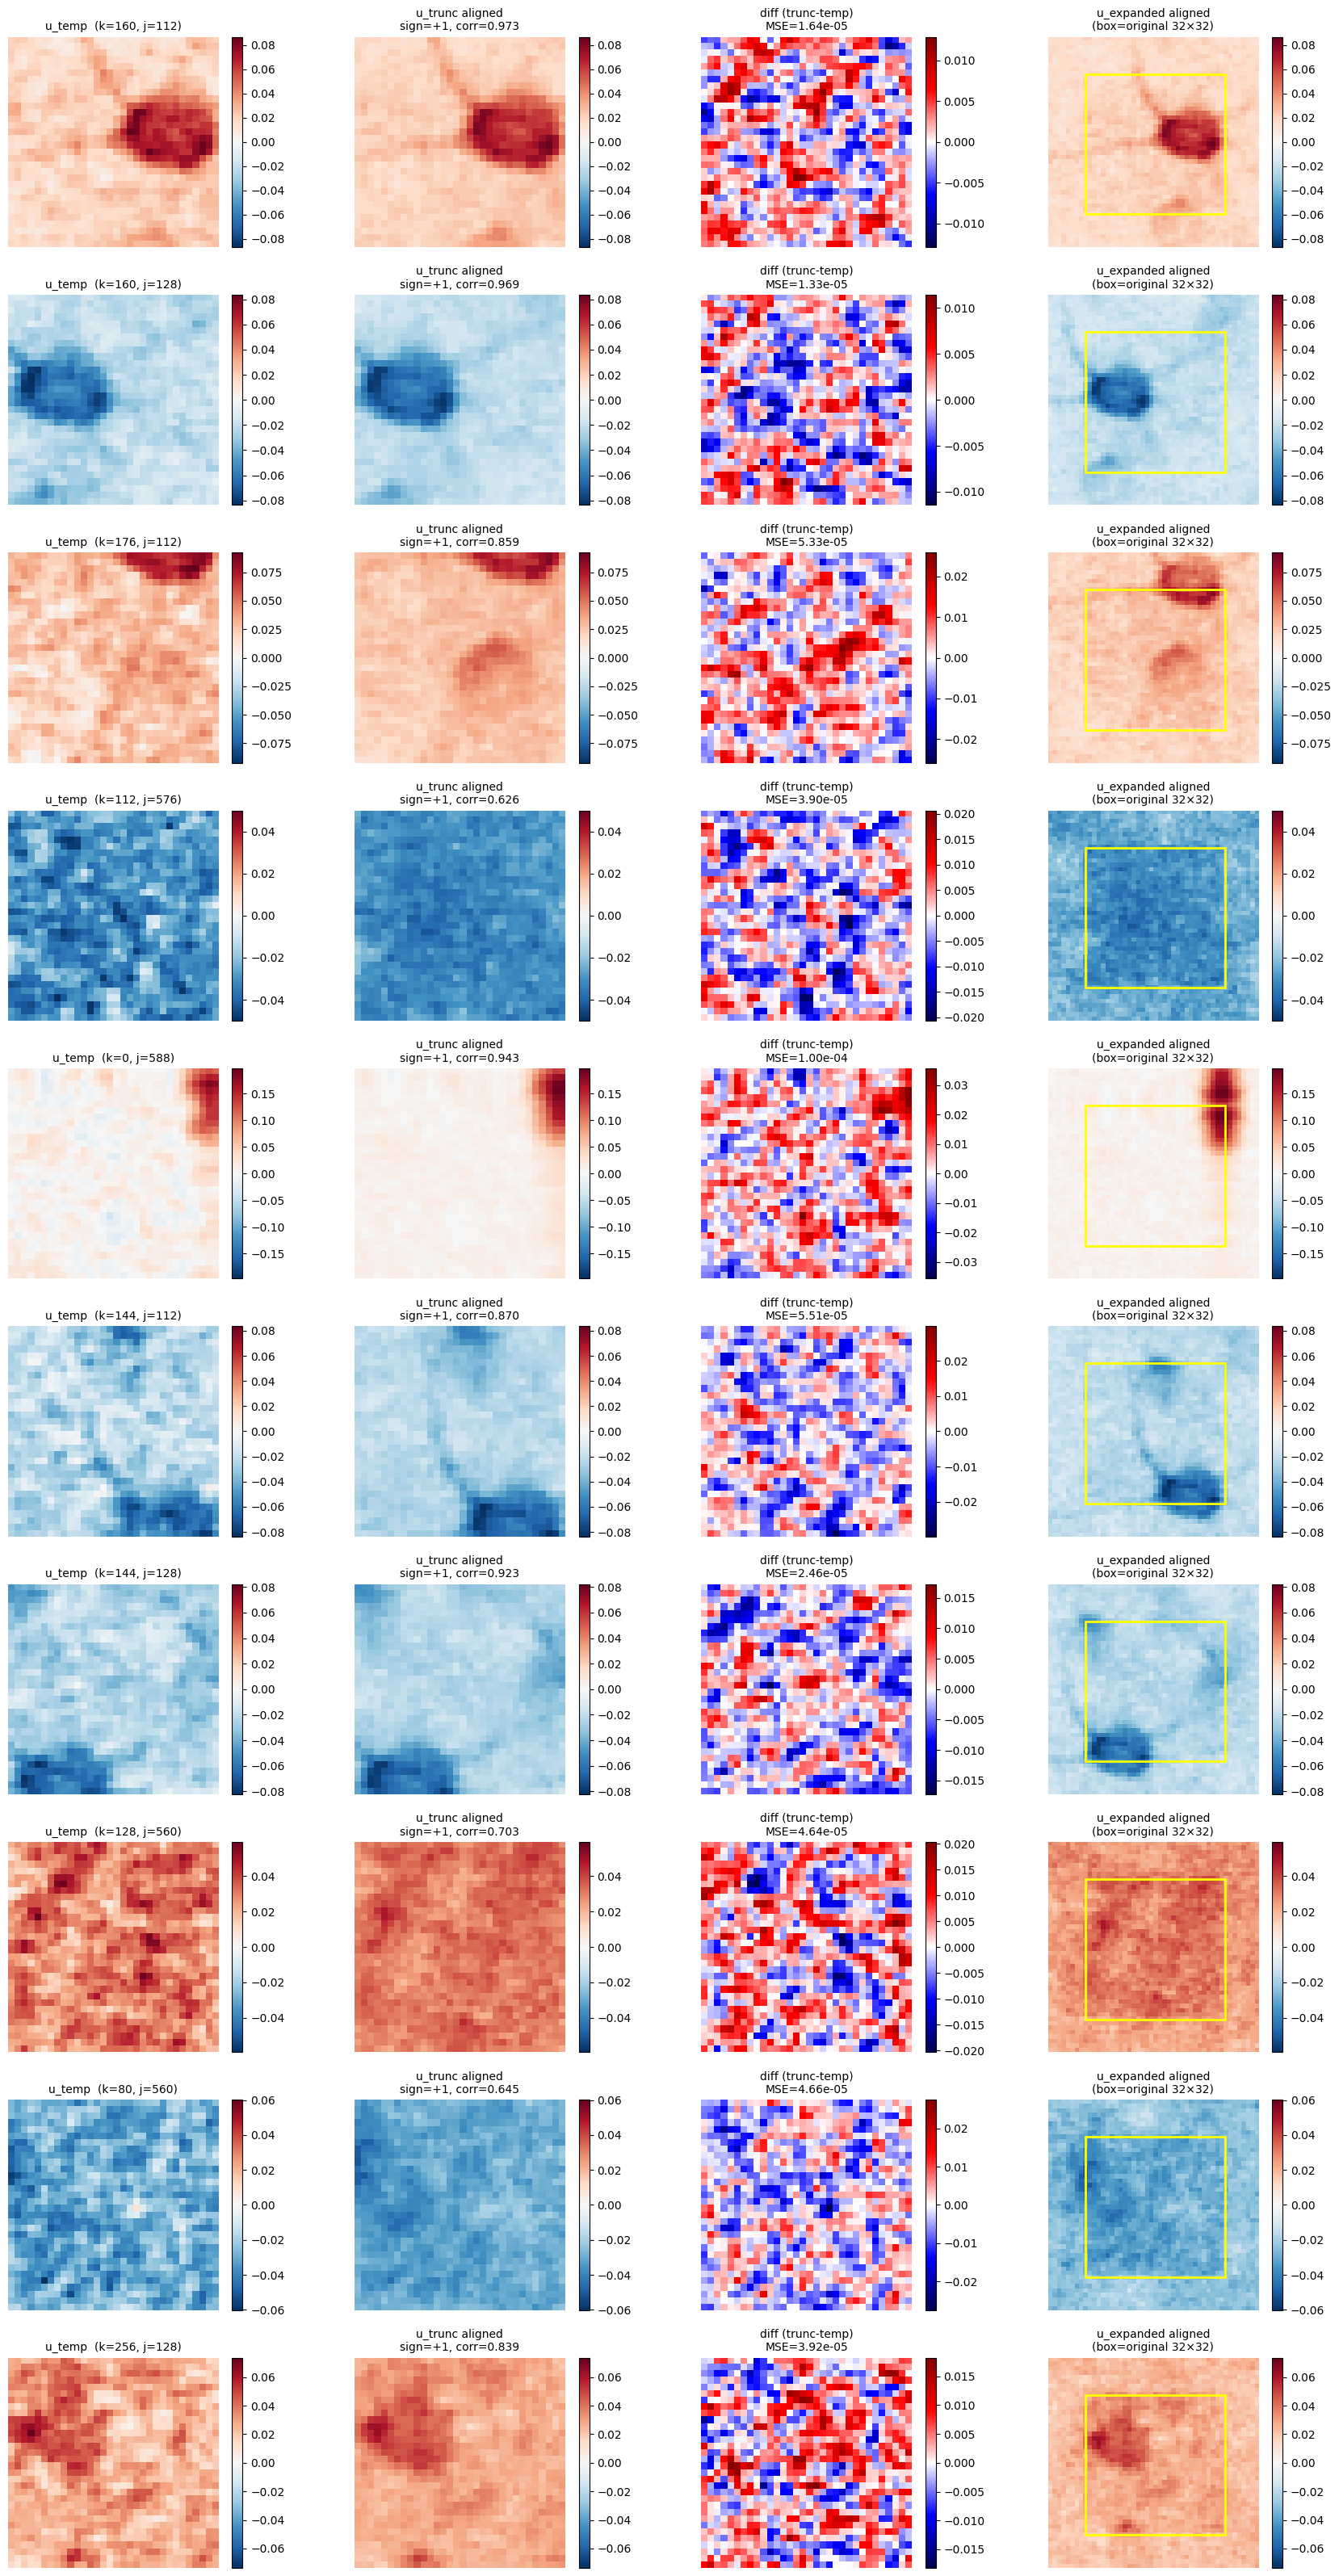

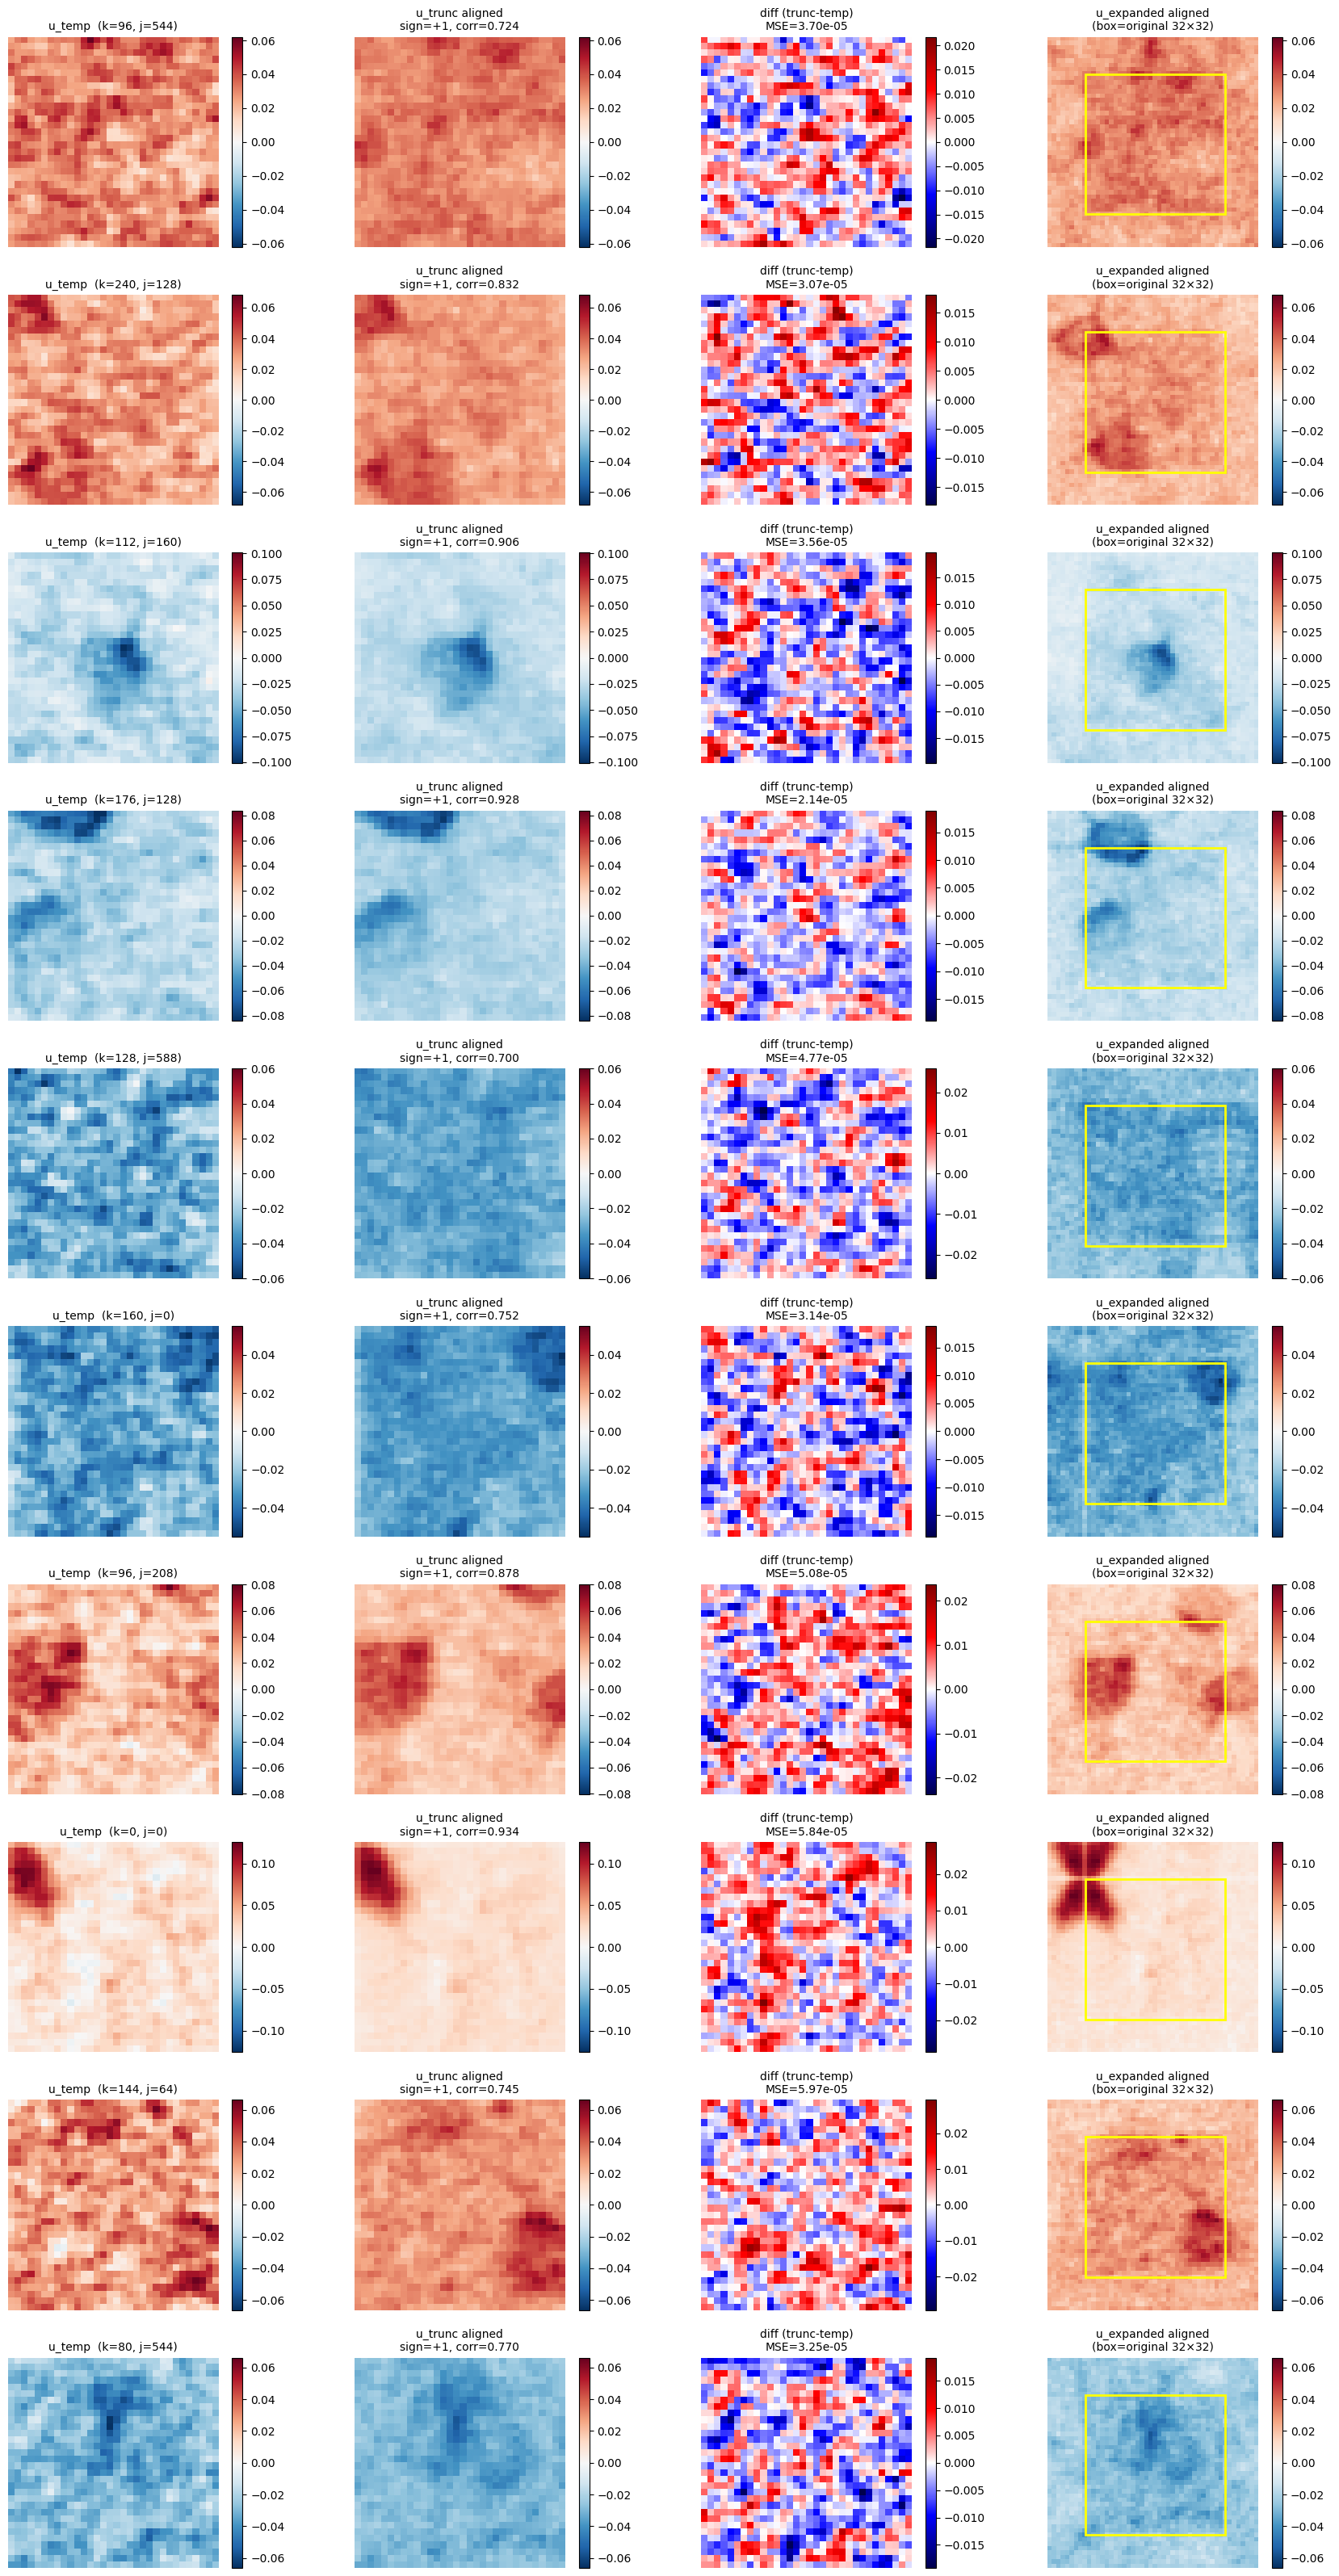

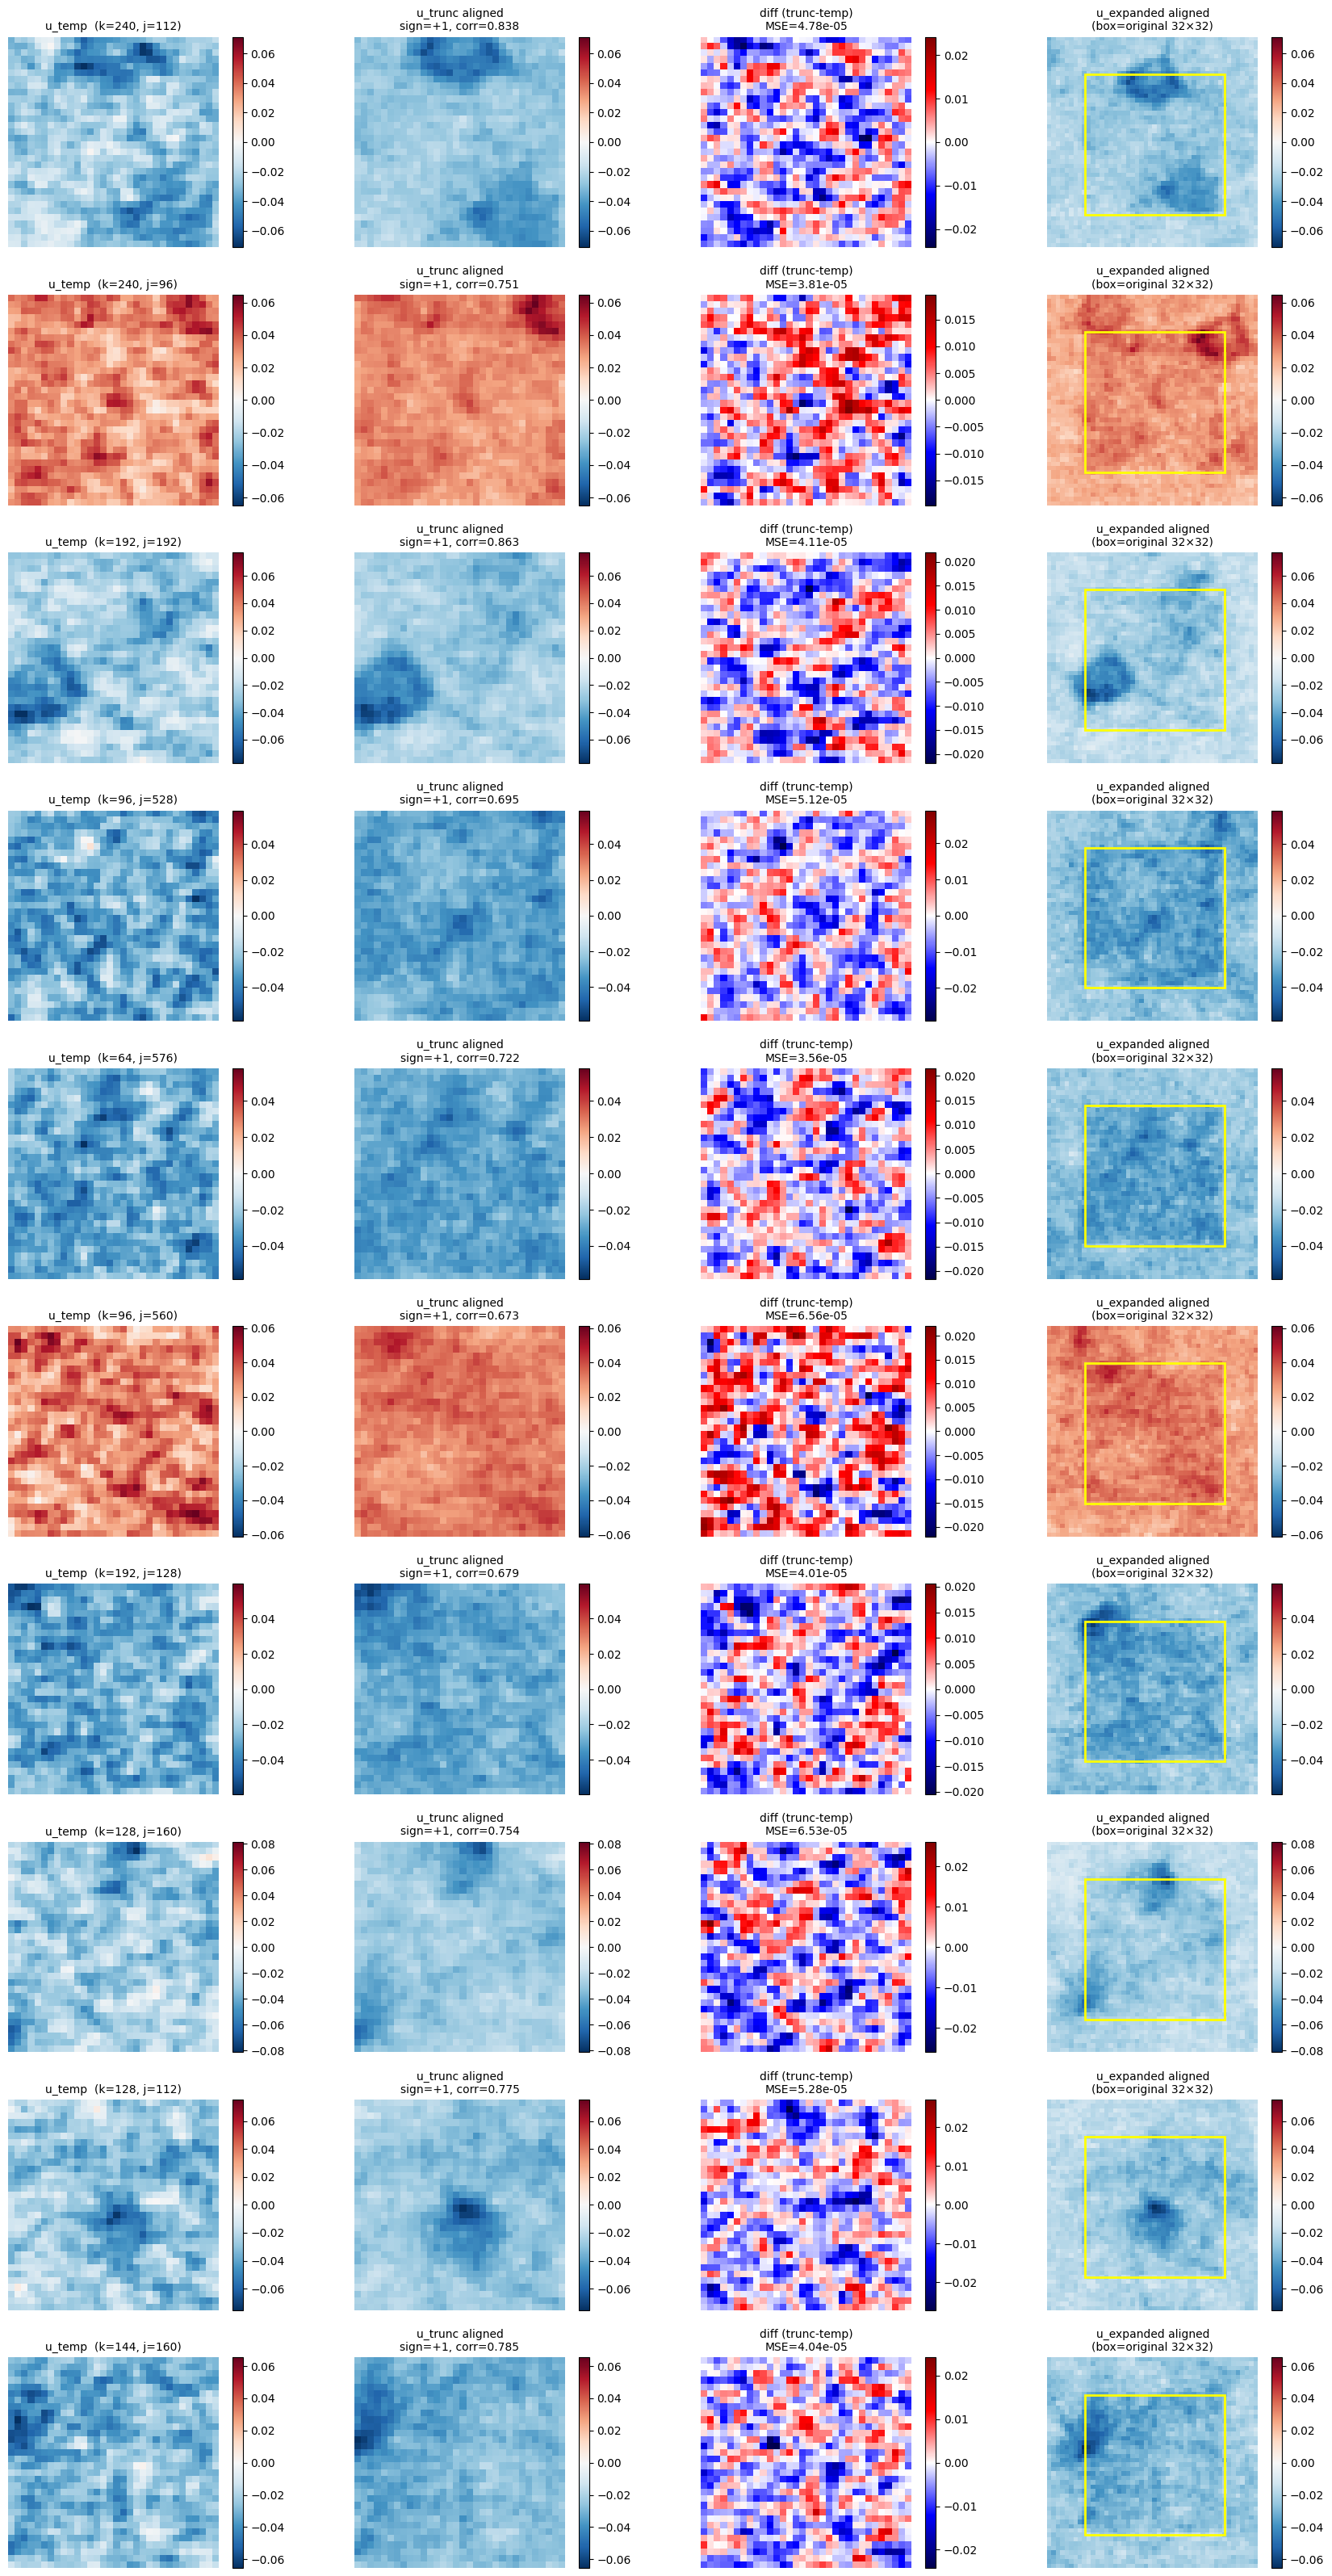

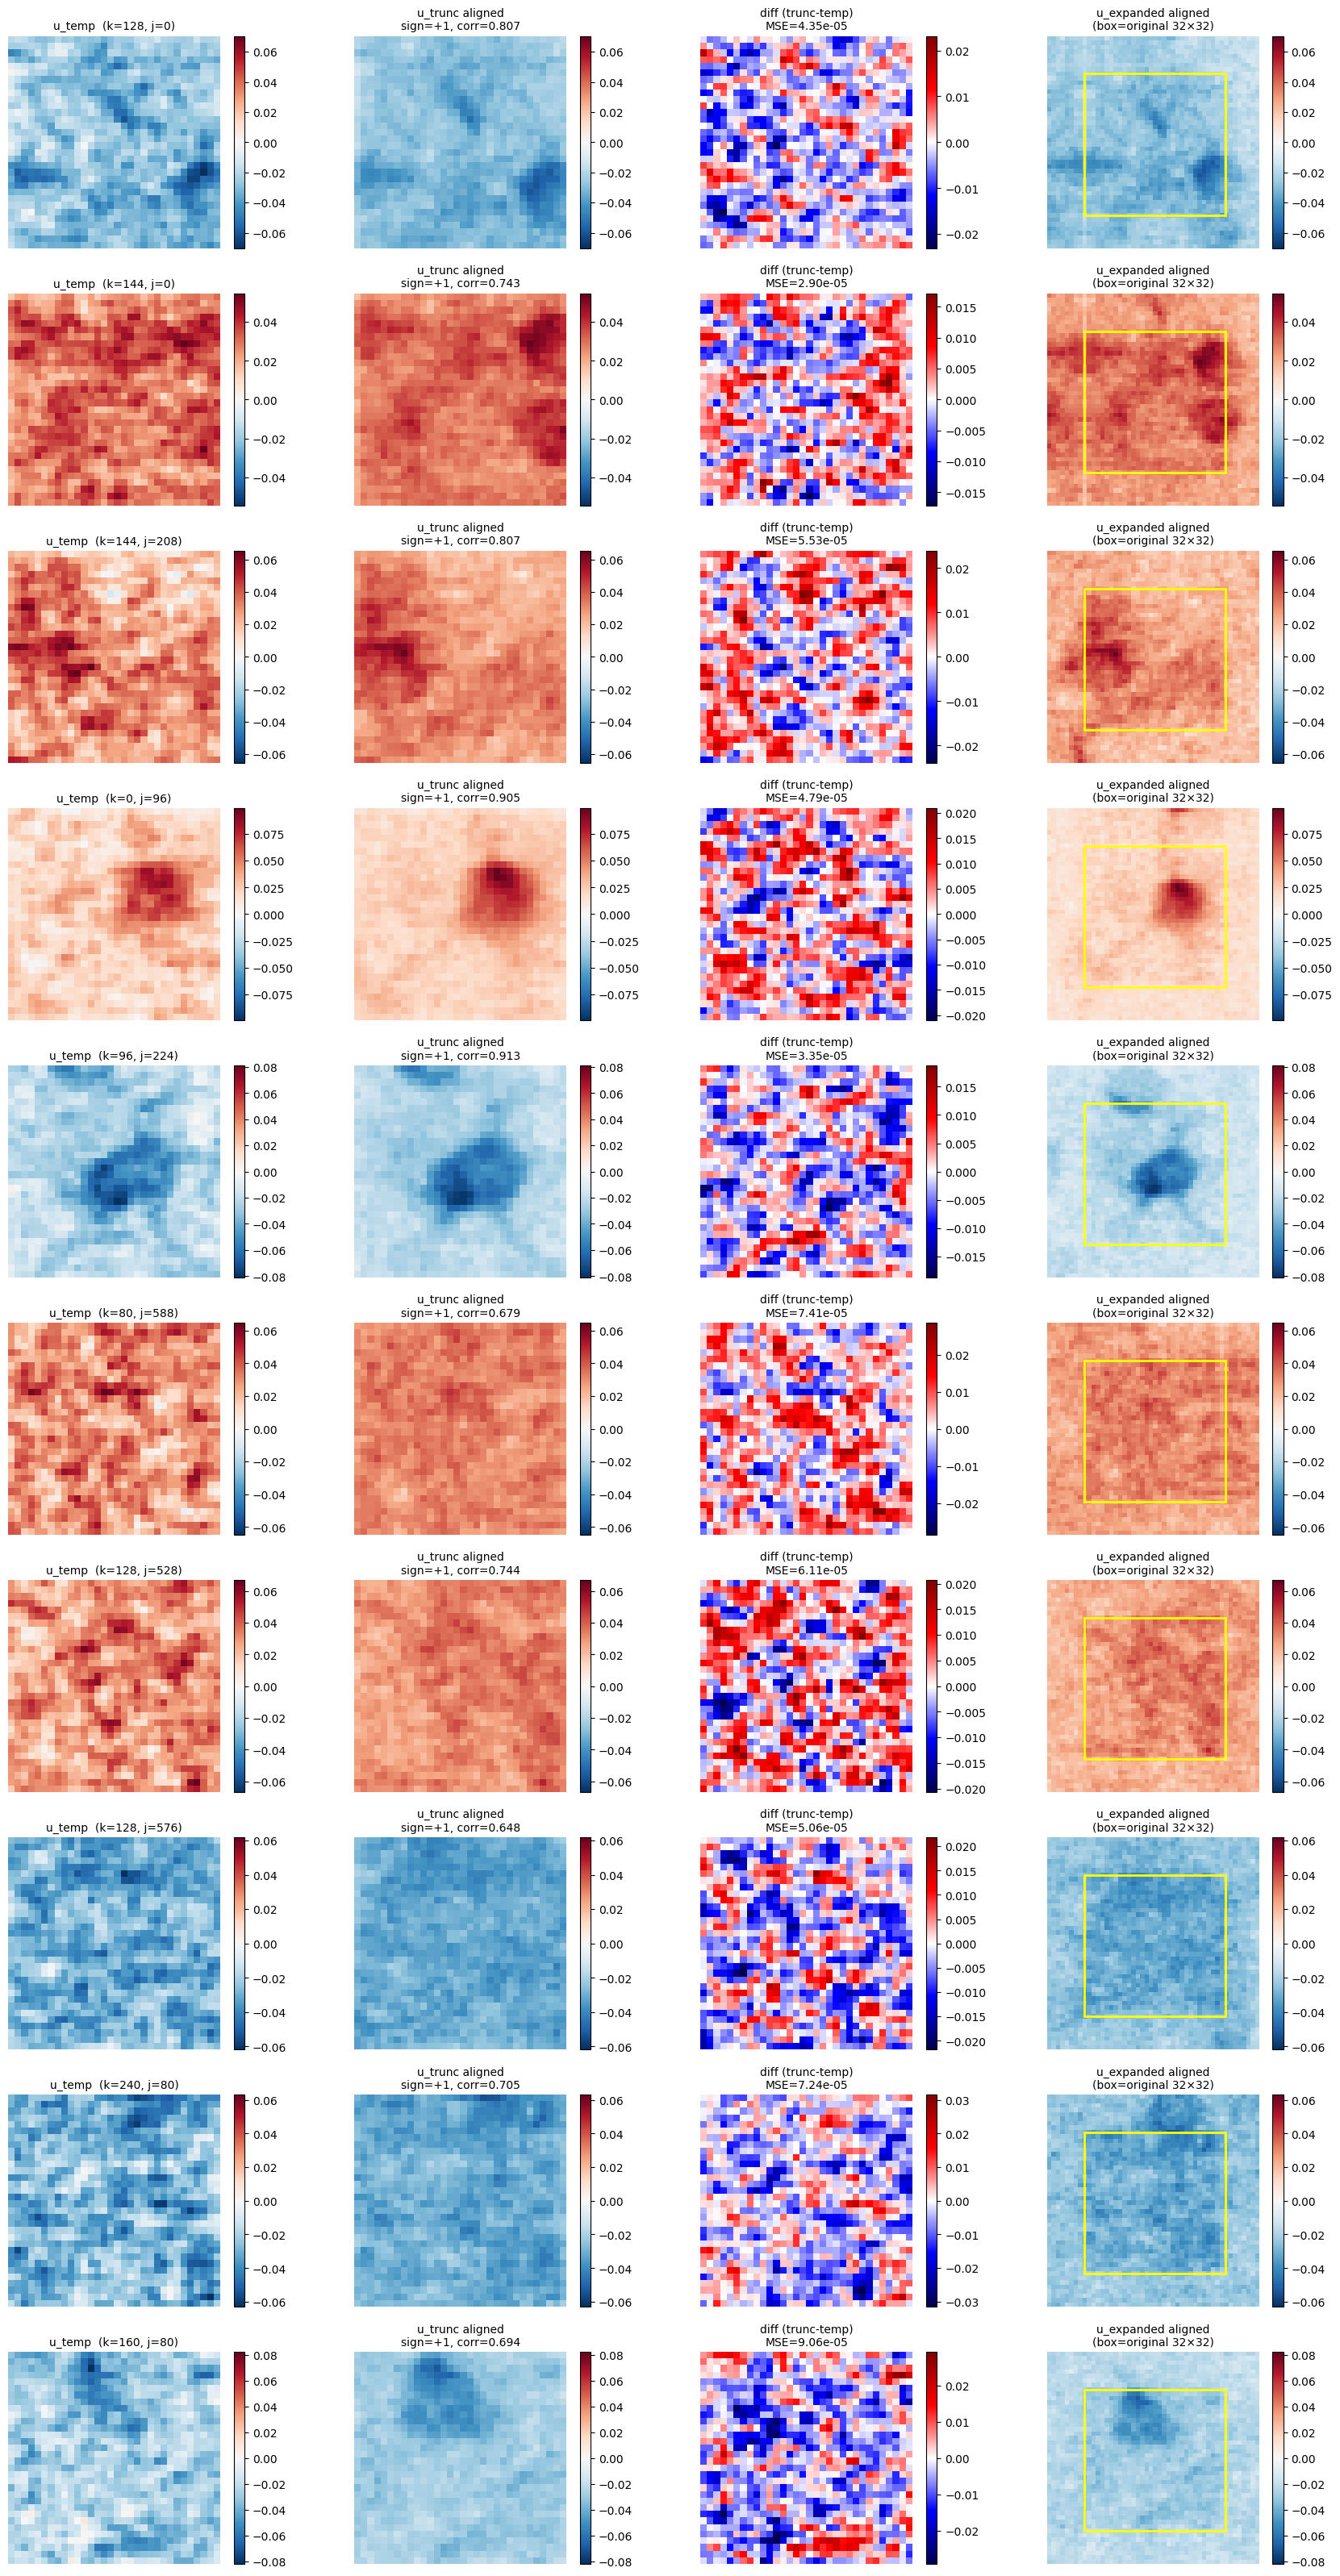

Saved 4 figures to: viz_blocks


In [5]:
pmd_arr_extu = pmd_decomposition_extend_u(
    dataset=my_data,
    block_sizes=(32,32),
    max_components=10,
    frame_batch_size=20000,
    device="cuda" if torch.cuda.is_available() else "cpu",
    pad_frac=0.25,
    ridge=0.0,
    viz={
      "enabled": True,
      "mode": "collect_top_comp0",
      "top_n": 40,
      "per_fig": 10,
      "out_dir": "viz_blocks",
      "prefix": "extU_topcells",
    }
)
